In [36]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import transformers
from dinov3_linear import DinoV3Linear

In [ ]:
images = glob.glob("./downloads/birds-200-species/CUB_200_2011/images/*/*")

In [45]:
ckpt_path = "./weights/model_best.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(ckpt_path, map_location=device)

ProcessorClass = getattr(transformers, ckpt["config"]["image_processor"]["image_processor_type"])
image_processor = ProcessorClass(**ckpt["config"]["image_processor"])
backbone = transformers.AutoModel.from_config(transformers.AutoConfig.for_model(**ckpt["config"]["backbone"]))
model = DinoV3Linear(
    backbone=backbone,
    num_classes=len(ckpt["config"]["classes"]),
    freeze_backbone=ckpt["config"].get("freeze_backbone", True),
).to(device)
classes = ckpt["config"]["classes"]

model.load_state_dict(ckpt["model_state_dict"])
model = model.eval()

def infer(image, device):
    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt").to(device)
        logits = model(inputs["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1).item()
        conf = probs[0, pred].item()
        pred_class = classes[pred]
        return pred_class, conf

Predicted: 150.Sage_Thrasher, Conf: 0.9993402361869812


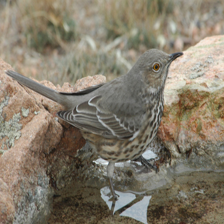

In [72]:
# predict on a single image
image_path = np.random.choice(images)
image = Image.open(image_path)
pred, conf = infer(image, device)
print(f"Predicted: {pred}, Conf: {conf}")
display(image.resize((224, 224)))

In [ ]:
# plot 30 images at once
plt.figure(figsize = (20,20))
for i, idx in enumerate(np.random.choice(len(images), size=30, replace=False)):
    image = Image.open(images[idx])
    label = os.path.basename(os.path.dirname(images[idx]))
    pred, conf = infer(image, device)
    
    plt.subplot(5, 6, i+1)
    plt.imshow(image.resize((224, 224)))
    plt.title(f"Gth: {label}\nPred: {pred}\nConf: {conf}", fontdict = {'fontsize' : 8})
    plt.axis("off")